<h1 align="center" style="color:#8DA9C4;">Computational Intelligence for Optimization - Project</h1>
<h3 align="center" style="color:#8DA9C4;">Group S - Sports League Optimization</h3>

---

### <span style="color:#8DA9C4;">Group Members</span>

<table>
  <thead style="color:#8DA9C4;">
    <tr>
      <th>Name</th>
      <th>Email</th>
      <th>Student ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Gustavo Veloso</td>
      <td>20240599@novaims.unl.pt</td>
      <td>20240599</td>
    </tr>
    <tr>
      <td>Leonor Mira</td>
      <td>20240658@novaims.unl.pt</td>
      <td>20240658</td>
    </tr>
    <tr>
      <td>Martim Tavares</td>
      <td>20240508@novaims.unl.pt</td>
      <td>20240508</td>
    </tr>
    <tr>
      <td>Santiago Taylor</td>
      <td>20240542@novaims.unl.pt</td>
      <td>20240542</td>
    </tr>
  </tbody>
</table>



---

<h2 style="color:#A3B18A;">Modelation Notebook</h2>

<p><strong style="color:#A3B18A;">Description:</strong></p>

<p>
This notebook focuses on building, training, and evaluating deep learning models for the classification of species.
</p>

<p>Key steps include:</p>

<ul>
  <li><strong style="color:#A3B18A;">Model Definition:</strong> Design and implement convolutional neural network (CNN) architectures tailored for the dataset.</li>
  <li><strong style="color:#A3B18A;">Compilation and Training: </strong> Compile the models with appropriate loss functions, optimizers, and metrics. Train the models using the preprocessed dataset with callbacks for early stopping and learning rate adjustments.</li>
  <li><strong style="color:#A3B18A;">Evaluation:</strong> Assess the model's performance on validation and test datasets using metrics such as accuracy, loss, and F1 score.</li>
  <li><strong style="color:#A3B18A;">Visualization:</strong> Plot training history to analyze the model's learning behavior, including loss and F1 score curves.</li>
</ul>

<p>
This notebook ensures the development of robust models capable of accurately classifying rare species.
</p>

---

# Tem que se mudar

<a id="toc"></a>

<h2 style="color:#8DA9C4;">Table of Contents</h2>

<ul style="list-style-type:none; padding-left:0;">
  <li><span style="color:#8DA9C4;">1.</span> <a href="#chapter1">Import the Libraries</a></li>
  <li><span style="color:#8DA9C4;">2.</span> <a href="#chapter2">Defining Core Classes</a></li>
  <li><span style="color:#8DA9C4;">3.</span> <a href="#chapter3">Defining Mutation</a></li>
  <li><span style="color:#8DA9C4;">4.</span> <a href="#chapter4">Defining Crossover</a></li>
  <li><span style="color:#8DA9C4;">5.</span> <a href="#chapter5">Selection Algorithm</a></li>
  <li><span style="color:#8DA9C4;">6.</span> <a href="#chapter6">Genetic Algorithm</a></li>
  <li><span style="color:#8DA9C4;">7.</span> <a href="#chapter7">Grid Search</a></li>
  <li><span style="color:#8DA9C4;">8.</span> <a href="#chapter8">Visualization</a></li>
  
</ul>

---

<h2 id="chapter1" style="color:#8DA9C4;">1. Import the Libraries and Load the Data</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>In this section, we import the necessary libraries required throughout this notebook.</p>

In [1]:
import sys
sys.path.append('..')

In [2]:
import random
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from typing import Callable
from copy import deepcopy
from tqdm import tqdm

In [3]:
# Check if the file exists
players_df = pd.read_csv("players(in).csv", index_col=0)

<h2 id="chapter2" style="color:#8DA9C4;">2. Defining Core Classes</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>


<p>This section defines the core classes that structure the logic of the evolutionary algorithm. These classes encapsulate fundamental concepts such as players, teams, and leagues, enabling modular and reusable management of data and operations throughout the notebook. They will later be used to assign players, apply genetic operators, and evaluate candidate solutions.
</p>

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>The defined classes provide a structured model for the player allocation problem under budget constraints and performance objectives. The main features of each class are described below:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Player:</strong> Represents an individual player with attributes such as name, position, skill level, and salary. Includes methods for comparison and unique identification.</li>
  <li><strong style="color:#8DA9C4;">Team:</strong> Represents a football team and manages the allocation of players by position. Calculates metrics like total salary and average skill, and checks whether the team exceeds the budget.</li>
  <li><strong style="color:#8DA9C4;">League:</strong> Holds a set of teams and applies genetic operations such as crossover and mutation. Evaluates the quality of the solution based on team balance and budget compliance.</li>
</ul>

<p>These abstractions are essential for organizing and efficiently manipulating the data throughout the simulation and optimization process.</p>

</div>


In [4]:
class Player():

    def __init__(self, player):
        self.name = player["Name"]
        self.position = player["Position"]
        self.skill = player["Skill"]
        self.salary = player["Salary (€M)"]

    def __repr__(self):
        return f"{self.name} - {self.position}"

    # para comparar jogadores com os mesmos dados
    def __eq__(self, other):
        if not isinstance(other, Player):
            return False
        return self.name == other.name and self.position == other.position

    def __hash__(self):  # NAO FACO A MINIMA
        return hash((self.name, self.position))

In [5]:
class Team():

    def __init__(self, name, budget):

        self.budget = budget
        self.name = name
        self.goalkeepers = []
        self.defenders = []
        self.midfielders = []
        self.forwards = []

    def add_player(self, player):
        if player.position == "GK":
            self.goalkeepers.append(player)
        if player.position == "DEF":
            self.defenders.append(player)
        if player.position == "MID":
            self.midfielders.append(player)
        if player.position == "FWD":
            self.forwards.append(player)

    def total_salary(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    def average_skill(self):
        return statistics.mean([p.skill for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    def over_budget(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards]) > self.budget

In [6]:
class League():

    def __init__(self, crossover_function, mutation_function): # deviamos meter aqui o budget
        self.crossover_function = crossover_function
        self.mutation_function = mutation_function
        self.teams = [
            Team("Team 1", 750),
            Team("Team 2", 750),
            Team("Team 3", 750),
            Team("Team 4", 750),
            Team("Team 5", 750)
        ]

    def valid_league(self):
        players = [p for t in self.teams for p in t.goalkeepers + t.defenders + t.midfielders + t.forwards]
        return len(set(players)) == len(players)


    def allocate_players_from_lists(self, goalkeepers, defenders, midfielders, forwards):
        # Clear teams
        for team in self.teams:
            team.goalkeepers = []
            team.defenders = []
            team.midfielders = []
            team.forwards = []

        for i, team in enumerate(self.teams):
            team.add_player(goalkeepers[i])
            team.add_player(defenders[i * 2])
            team.add_player(defenders[i * 2 + 1])
            team.add_player(midfielders[i * 2])
            team.add_player(midfielders[i * 2 + 1])
            team.add_player(forwards[i * 2])
            team.add_player(forwards[i * 2 + 1])


    def draft_players(self, players):

        # Separate players by position
        goalkeepers = [p for p in players if p.position == "GK"]
        defenders = [p for p in players if p.position == "DEF"]
        midfielders = [p for p in players if p.position == "MID"]
        forwards = [p for p in players if p.position == "FWD"]

        random.shuffle(goalkeepers)
        random.shuffle(defenders)
        random.shuffle(midfielders)
        random.shuffle(forwards)

        self.allocate_players_from_lists(goalkeepers, defenders, midfielders, forwards)


    def show_teams(self):
        for team in self.teams:
            print(f"\n{team.name}")
            print("──────────────")
            for player in team.goalkeepers + team.defenders + team.midfielders + team.forwards:
                print(f"{player.name} - {player.position}")
        print("──────────────")

    def fitness(self):
        std = statistics.stdev([team.average_skill() for team in self.teams])
        over_budget_count = sum(team.over_budget() for team in self.teams)
        return std + over_budget_count


    def player_positions(self):
        player_positions = {
            "GK": [p for t in self.teams for p in t.goalkeepers],
            "DEF": [p for t in self.teams for p in t.defenders],
            "MID": [p for t in self.teams for p in t.midfielders],
            "FWD": [p for t in self.teams for p in t.forwards]
        }
        return player_positions

    #def mutation(self, mut_prob):
        #return self

    def mutation(self, mut_prob):
        player_positions = self.player_positions()

        self.mutation_function(player_positions["GK"], mut_prob)
        self.mutation_function(player_positions["DEF"], mut_prob)
        self.mutation_function(player_positions["MID"], mut_prob)
        self.mutation_function(player_positions["FWD"], mut_prob)

        mutated_team = League(self.crossover_function, self.mutation_function)
        mutated_team.allocate_players_from_lists(player_positions["GK"], player_positions["DEF"], player_positions["MID"], player_positions["FWD"])

        return mutated_team


    def crossover(self, other_solution):
        parent1_positions = self.player_positions()
        parent2_positions = other_solution.player_positions()

        offspring1_goalkeepers, offspring2_goalkeepers = self.crossover_function(parent1_positions["GK"], parent2_positions["GK"])
        offspring1_defenders, offspring2_defenders = self.crossover_function(parent1_positions["DEF"], parent2_positions["DEF"])
        offspring1_midfielders, offspring2_midfielders = self.crossover_function(parent1_positions["MID"], parent2_positions["MID"])
        offspring1_forwards, offspring2_forwards = self.crossover_function(parent1_positions["FWD"], parent2_positions["FWD"])

        # Create new leagues and allocate players
        offspring1 = League(self.crossover_function, self.mutation_function)
        offspring1.allocate_players_from_lists(offspring1_goalkeepers, offspring1_defenders, offspring1_midfielders, offspring1_forwards)

        offspring2 = League(self.crossover_function, self.mutation_function)
        offspring2.allocate_players_from_lists(offspring2_goalkeepers, offspring2_defenders, offspring2_midfielders, offspring2_forwards)

        return offspring1, offspring2


<h2 id="chapter3" style="color:#8DA9C4;">3. Defining Mutation</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section implements the mutation operators used to introduce diversity into candidate solutions. Mutation functions apply more abrupt transformations than crossover, modifying team configurations in a way that allows the algorithm to escape local optima and explore new areas of the solution space.</p>


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>The mutation operators modify team line-ups in various ways, helping the genetic algorithm to search the solution space more thoroughly. The defined mutations include:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Swap Mutation:</strong> Randomly selects two player positions within a team and swaps their places, preserving team size and composition.</li>
  <li><strong style="color:#8DA9C4;">Shift Mutation:</strong> Selects a random subsequence of players within the team and performs a right circular shift — the last player in the selected range moves to the first position, and all others shift one place to the right.</li>
  <li><strong style="color:#8DA9C4;">Inversion Mutation:</strong> Selects a subsequence of players and reverses their order, introducing larger reordering effects.</li>
</ul>

<p>These mutation strategies ensure both small perturbations and larger reconfigurations, fostering a balance between exploration and exploitation in the evolutionary process.</p>

</div>


In [7]:
def shift_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)

    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        sub = new_representation[first_idx:second_idx + 1]
        sub = [sub[-1]] + sub[:-1]
        new_representation[first_idx:second_idx + 1] = sub

    return new_representation

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![shift mutation.png](<attachment:shift mutation.png>)

</div>
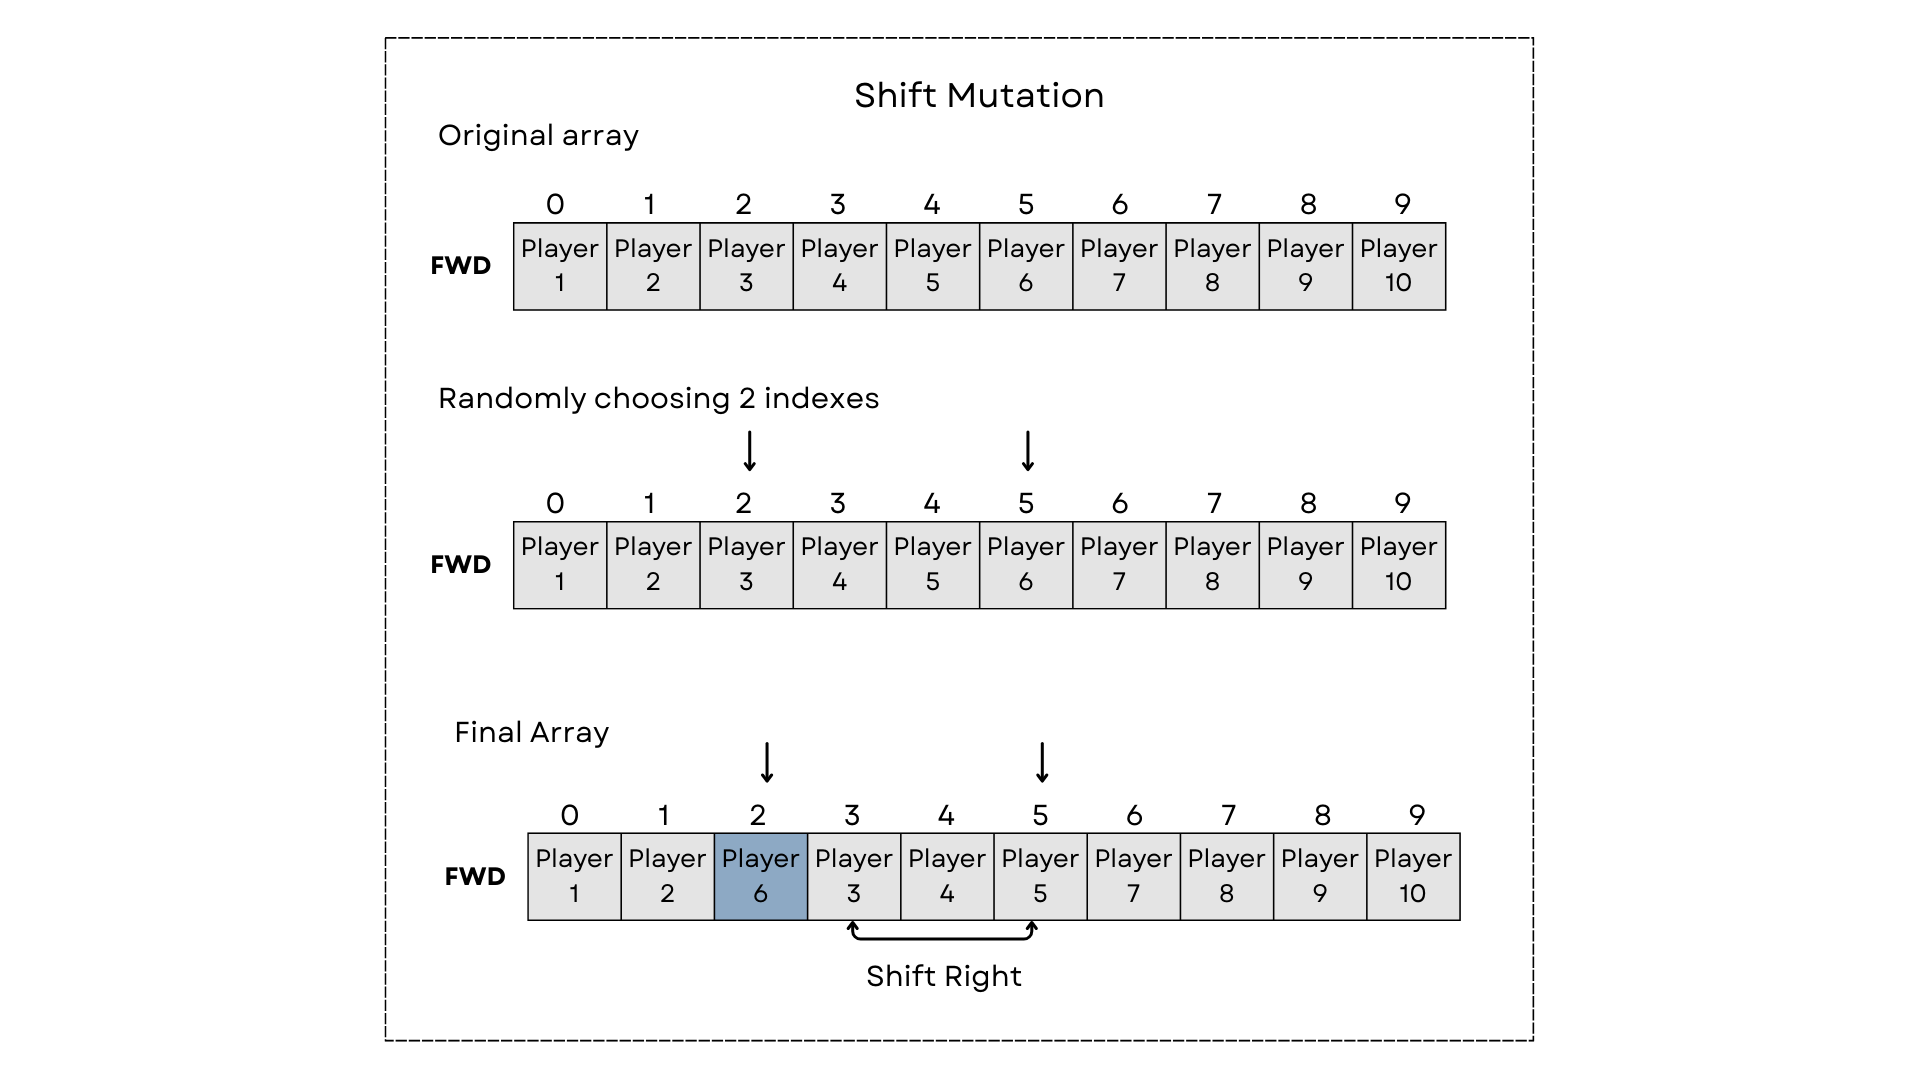

In [8]:
def invertion_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)
    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        new_representation[first_idx:second_idx + 1] = reversed(new_representation[first_idx:second_idx + 1])

    return new_representation


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">


![invertion mutation-2.png](<attachment:invertion mutation-2.png>)

</div>
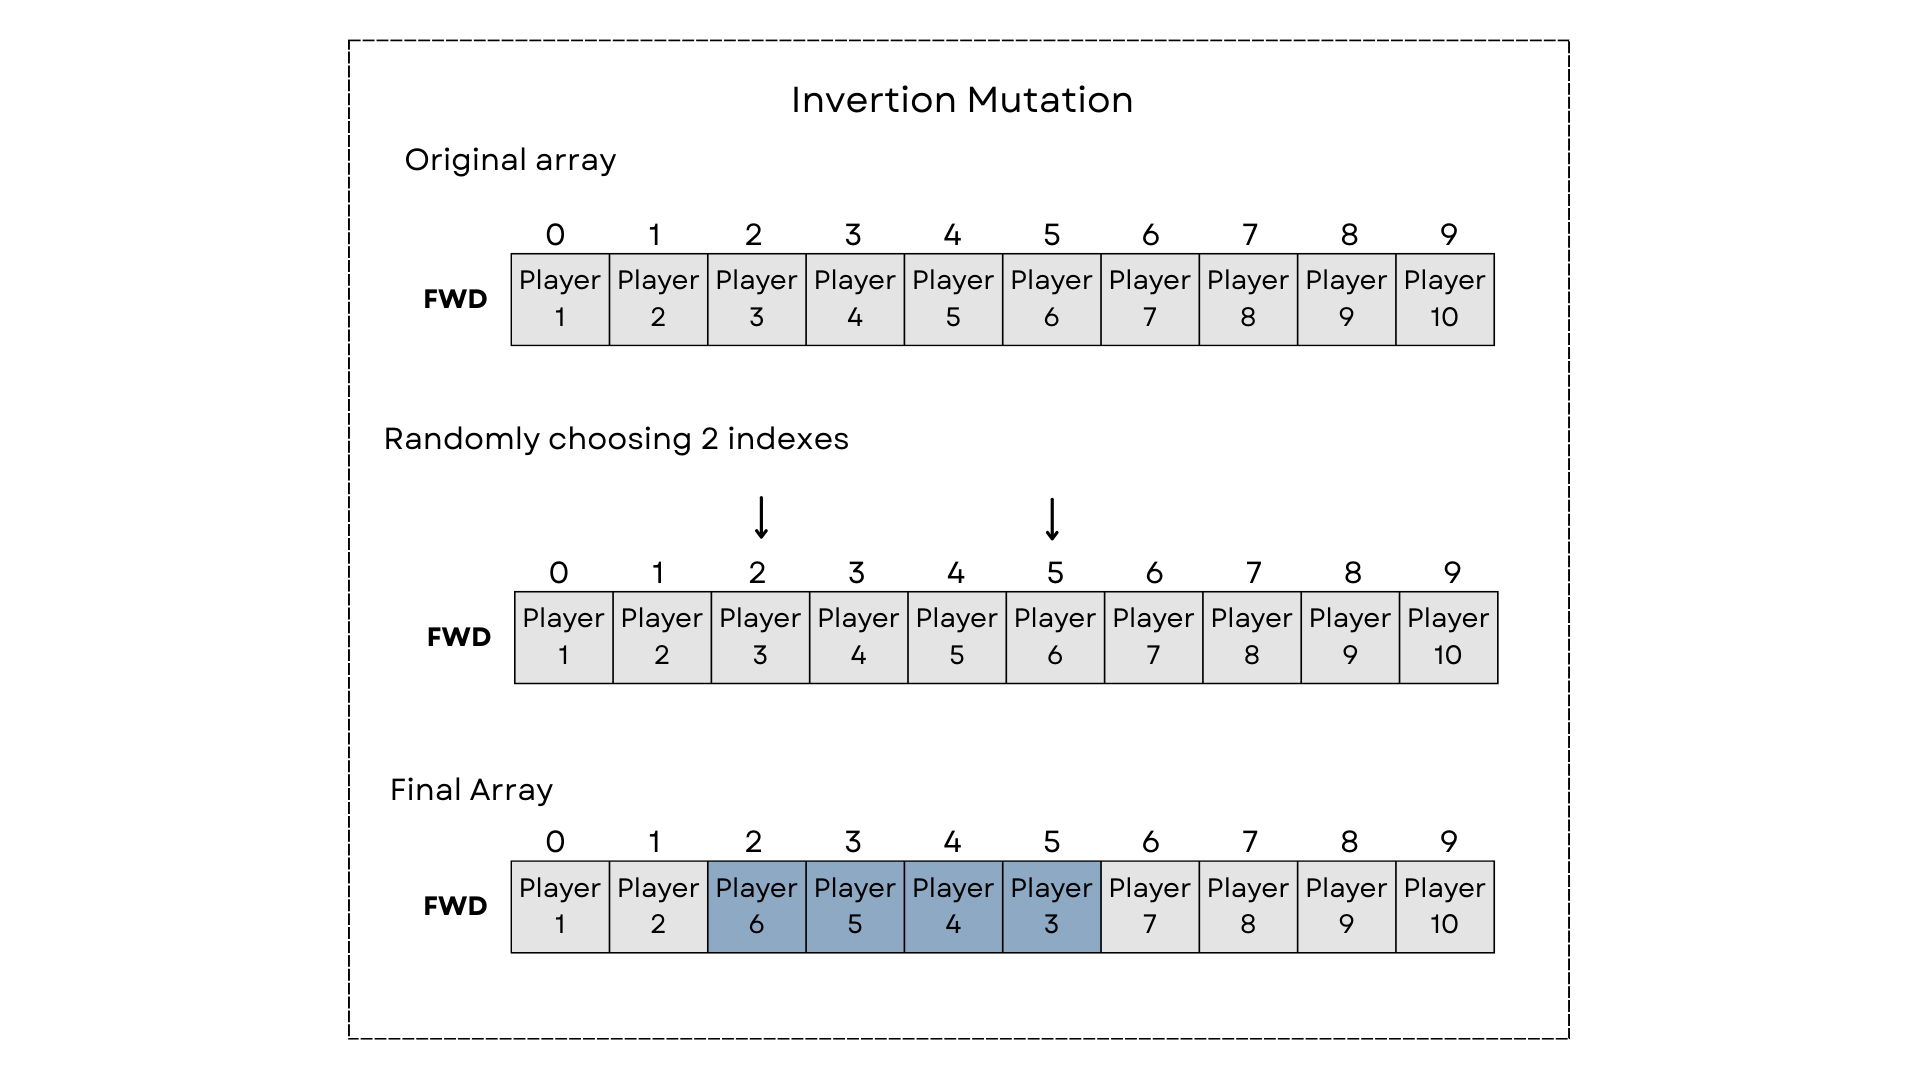

In [9]:
def swap_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)

    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx
        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        new_representation[first_idx] = repr[second_idx]
        new_representation[second_idx] = repr[first_idx]

        return new_representation

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">


![swap mutation-2.png](<attachment:swap mutation-2.png>)

</div>
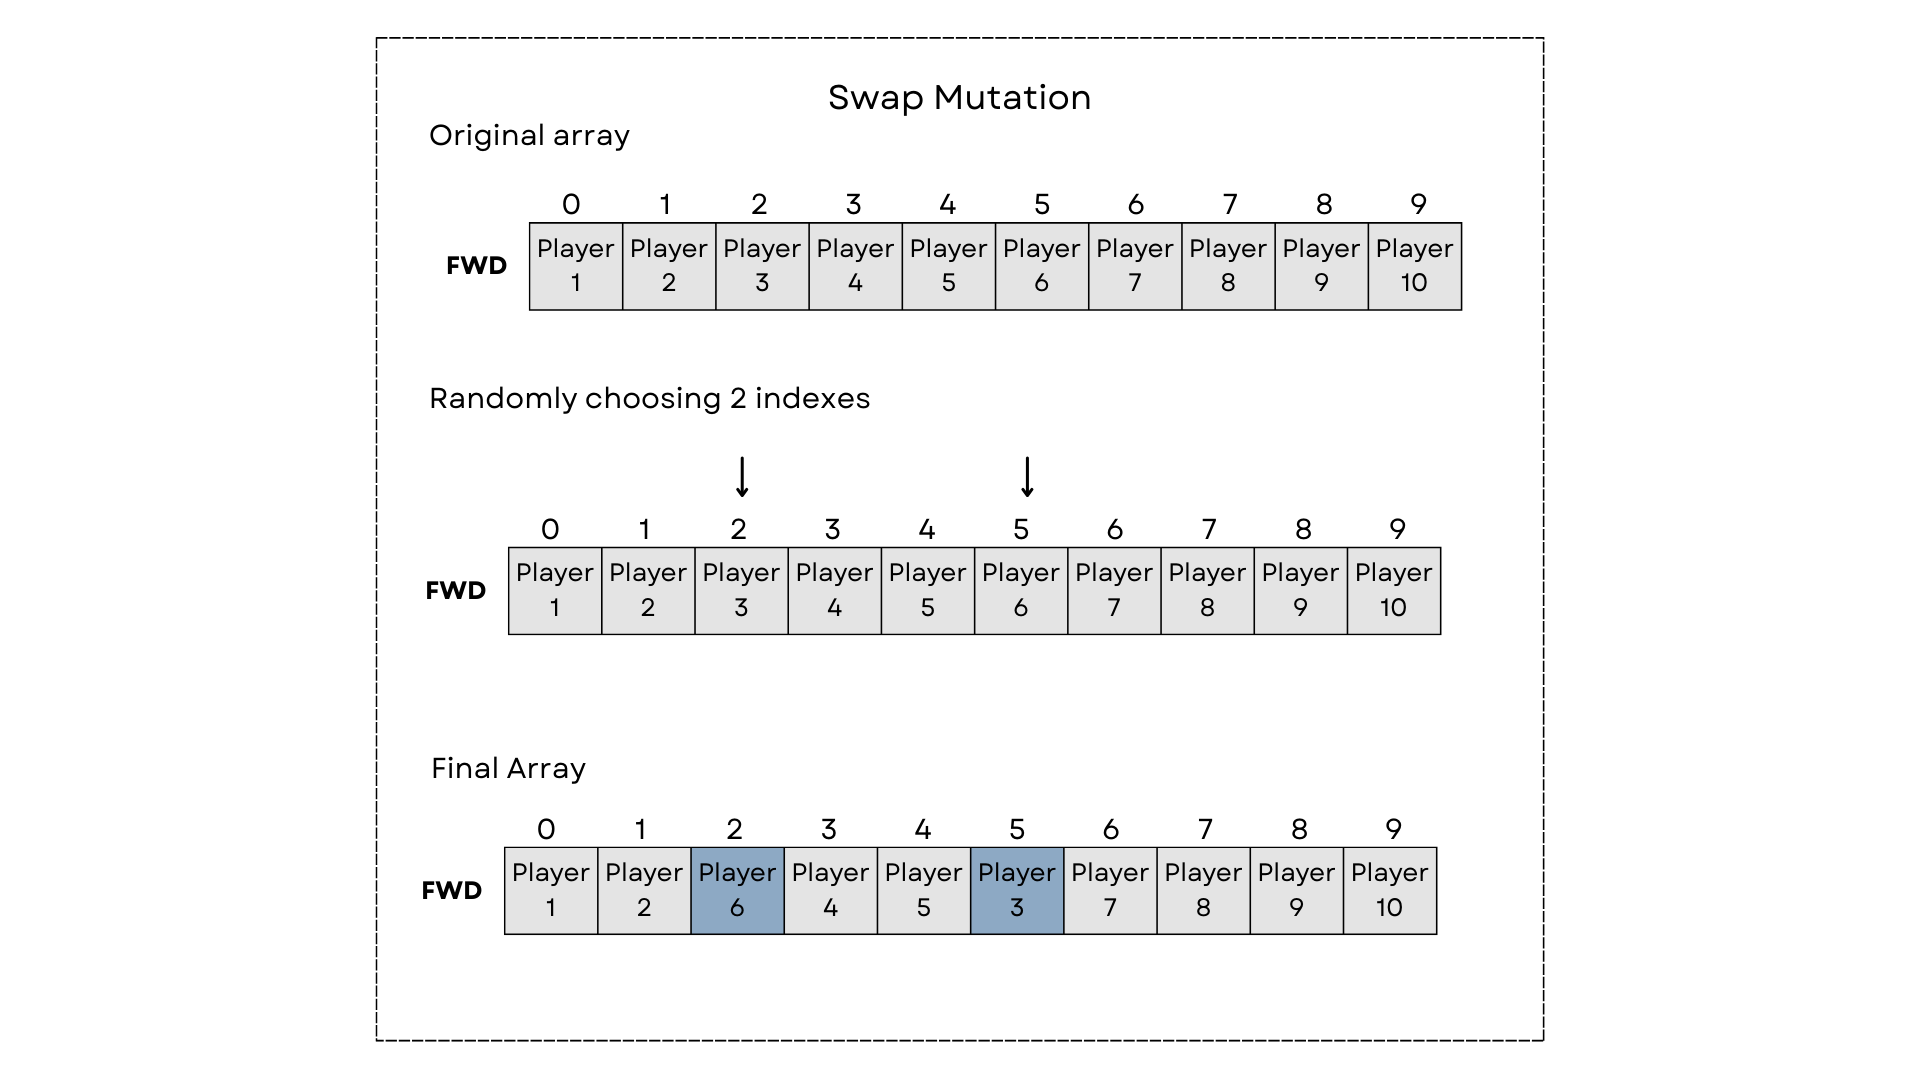

<h2 id="chapter4" style="color:#8DA9C4;">4. Defining Crossover</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section defines the crossover operator used in the genetic algorithm. Crossover is responsible for combining information from two parent solutions to generate new offspring, allowing the algorithm to inherit desirable traits and explore new configurations.</p>


<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>The crossover operator implemented here is the <strong>Cycle Crossover (CX)</strong>, a method designed to handle permutation-based representations, such as team or player orderings. It creates offspring by preserving position-specific information from both parents without introducing duplicates.</p>

<ul>
  <li><strong style="color:#8DA9C4;">Cycle Detection:</strong> Starting from a random index, the algorithm traces a cycle by matching values between the two parents until it loops back to the starting point. This ensures structural consistency in the child solutions.</li>
  <li><strong style="color:#8DA9C4;">Alternating Inheritance:</strong> The offspring inherits elements from one parent at the cycle indices and from the other parent at all remaining positions, maintaining valid and complete permutations.</li>
  <li><strong style="color:#8DA9C4;">String Support:</strong> If the input representations are strings, the resulting offspring are returned as strings as well, enabling flexible usage.</li>
</ul>

<p>This operator maintains the uniqueness of elements in permutation-based genomes, making it ideal for problems like player or team assignment, where duplicates are not allowed.</p>

</div>


In [10]:
def swap_crossover(parent1_repr: str | list, parent2_repr: str | list):

    size = len(parent1_repr)
    offspring1_repr = parent1_repr.copy()
    offspring2_repr = parent1_repr.copy()

    def swap(parent1_repr, parent2_repr):
        offspring_repr = parent1_repr.copy()
        # Randomly choose 1 position to perform a swap
        swap_positions = random.sample(range(size), 1)

        for pos in swap_positions:
            val_from_p2 = parent2_repr[pos]
            index_in_child = offspring_repr.index(val_from_p2)

            offspring_repr[pos], offspring_repr[index_in_child] = offspring_repr[index_in_child], offspring_repr[pos]

        return offspring_repr

    offspring1_repr = swap(parent1_repr=parent1_repr, parent2_repr=parent2_repr)
    offspring2_repr = swap(parent1_repr=parent2_repr, parent2_repr=parent1_repr)

    return offspring1_repr, offspring2_repr

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![swap crossover.png](<attachment:swap crossover.png>)

</div>
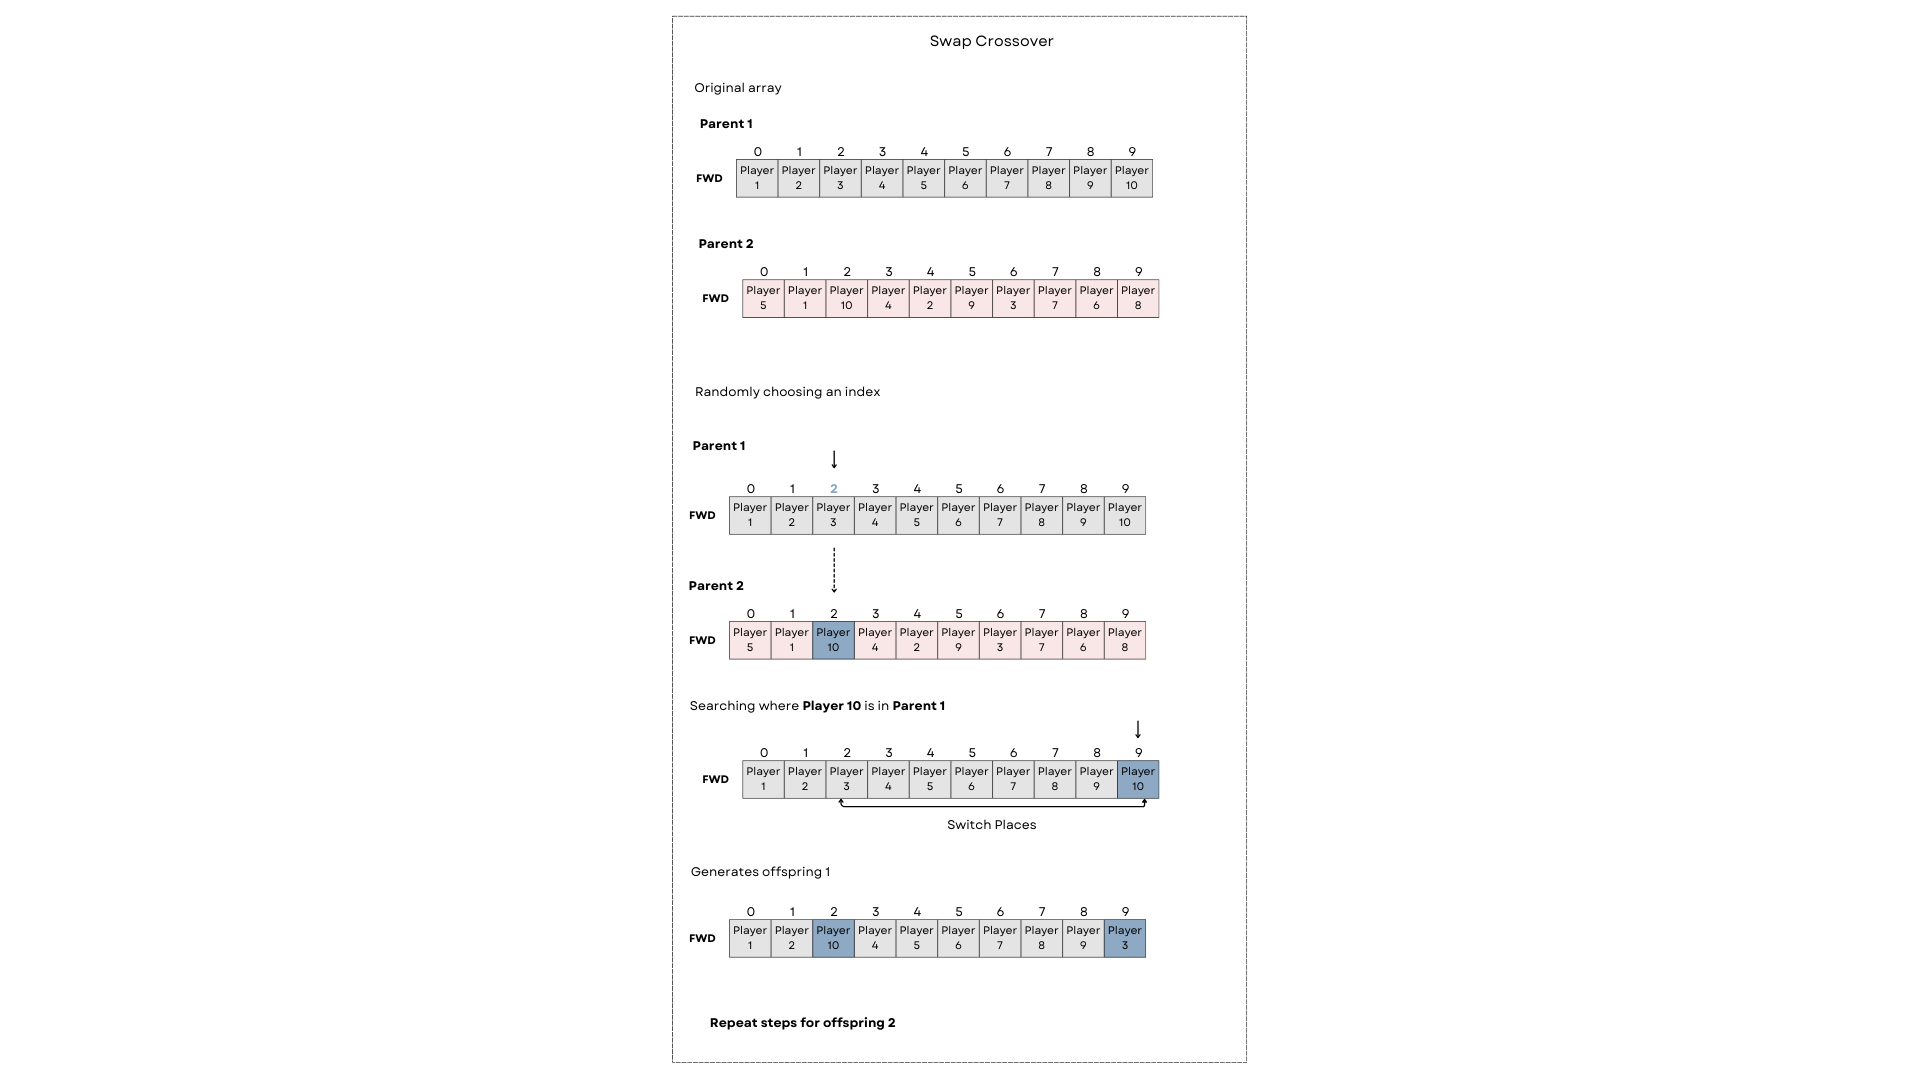

In [11]:
def cycle_crossover(parent1_repr, parent2_repr):
    initial_random_idx = random.randint(0, len(parent1_repr) -1)

    cycle_idxs = [initial_random_idx]
    current_cycle_idx = initial_random_idx

    while True:
        value_parent2 = parent2_repr[current_cycle_idx]

        next_cycle_idx = parent1_repr.index(value_parent2)

        if next_cycle_idx in cycle_idxs:
            break

        cycle_idxs.append(next_cycle_idx)
        current_cycle_idx = next_cycle_idx

    offspring1_repr = []
    offspring2_repr = []

    for idx in range(len(parent1_repr)):
        if idx in cycle_idxs:
            offspring1_repr.append(parent2_repr[idx])
            offspring2_repr.append(parent1_repr[idx])

        else:
            offspring1_repr.append(parent1_repr[idx])
            offspring2_repr.append(parent2_repr[idx])

    if isinstance(parent1_repr, str) and isinstance(parent2_repr, str):
        offspring1_repr = "". join(offspring1_repr)
        offspring2_repr = "". join(offspring2_repr)

    return offspring1_repr, offspring2_repr

<h2 id="chapter5" style="color:#8DA9C4;">5. Selection Algorithm</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p></p>

In [ ]:
def tournament_selection(population: list[League], maximization: bool, tournament_size: int = 4):

    tournament = random.sample(population, tournament_size)
    return deepcopy(get_best_ind(tournament, maximization))

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

![tournament Selection.png](<attachment:tournament Selection.png>)

</div>
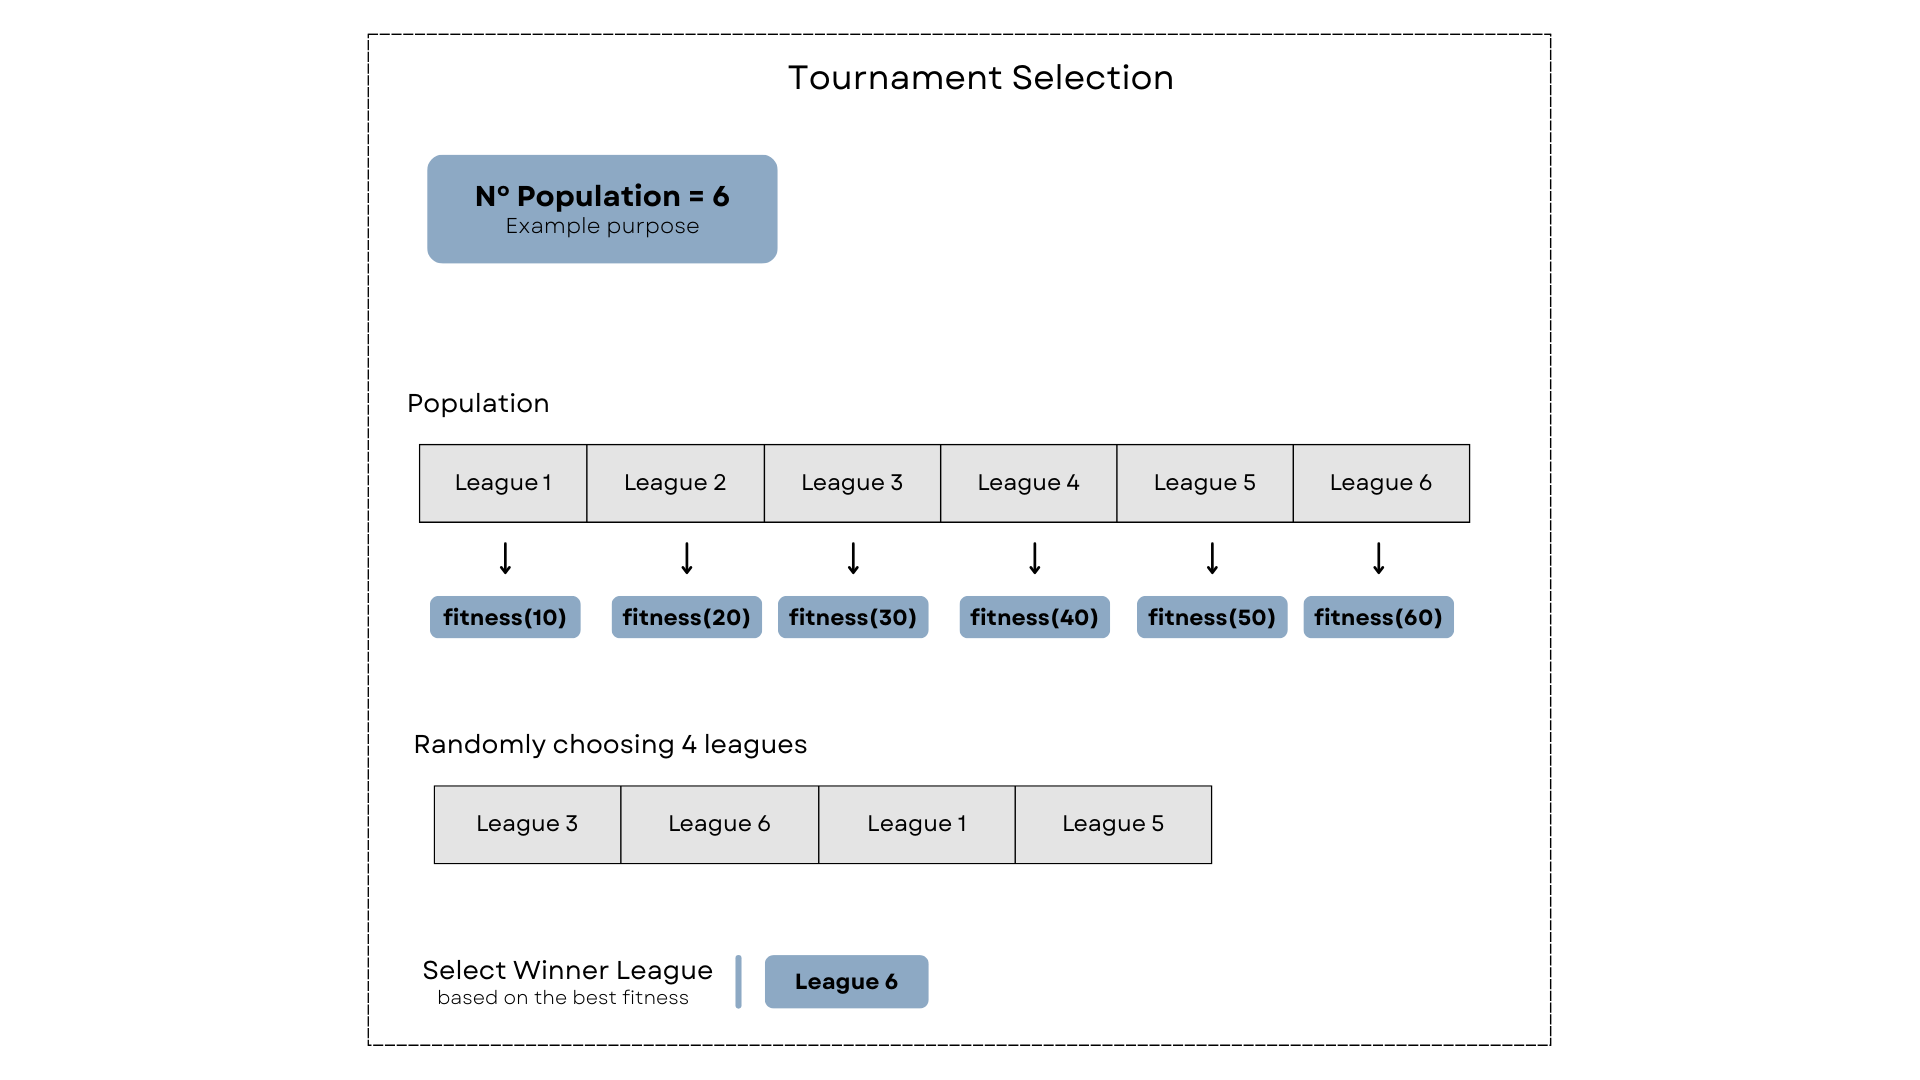

In [ ]:
def fitness_proportionate_selection(population: list[League], maximization: bool):
    # total_fitness = sum([ind.fitness() for ind in population])

    if maximization:
        fitness_values = [ind.fitness() for ind in population]
    else:
        # Minimization: Use the inverse of the fitness value
        # Lower fitness should have higher probability of being selected
        fitness_values = [1 / ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    # Generate random number between 0 and total
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0
    # For each individual, check if random number is inside the individual's "box"
    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

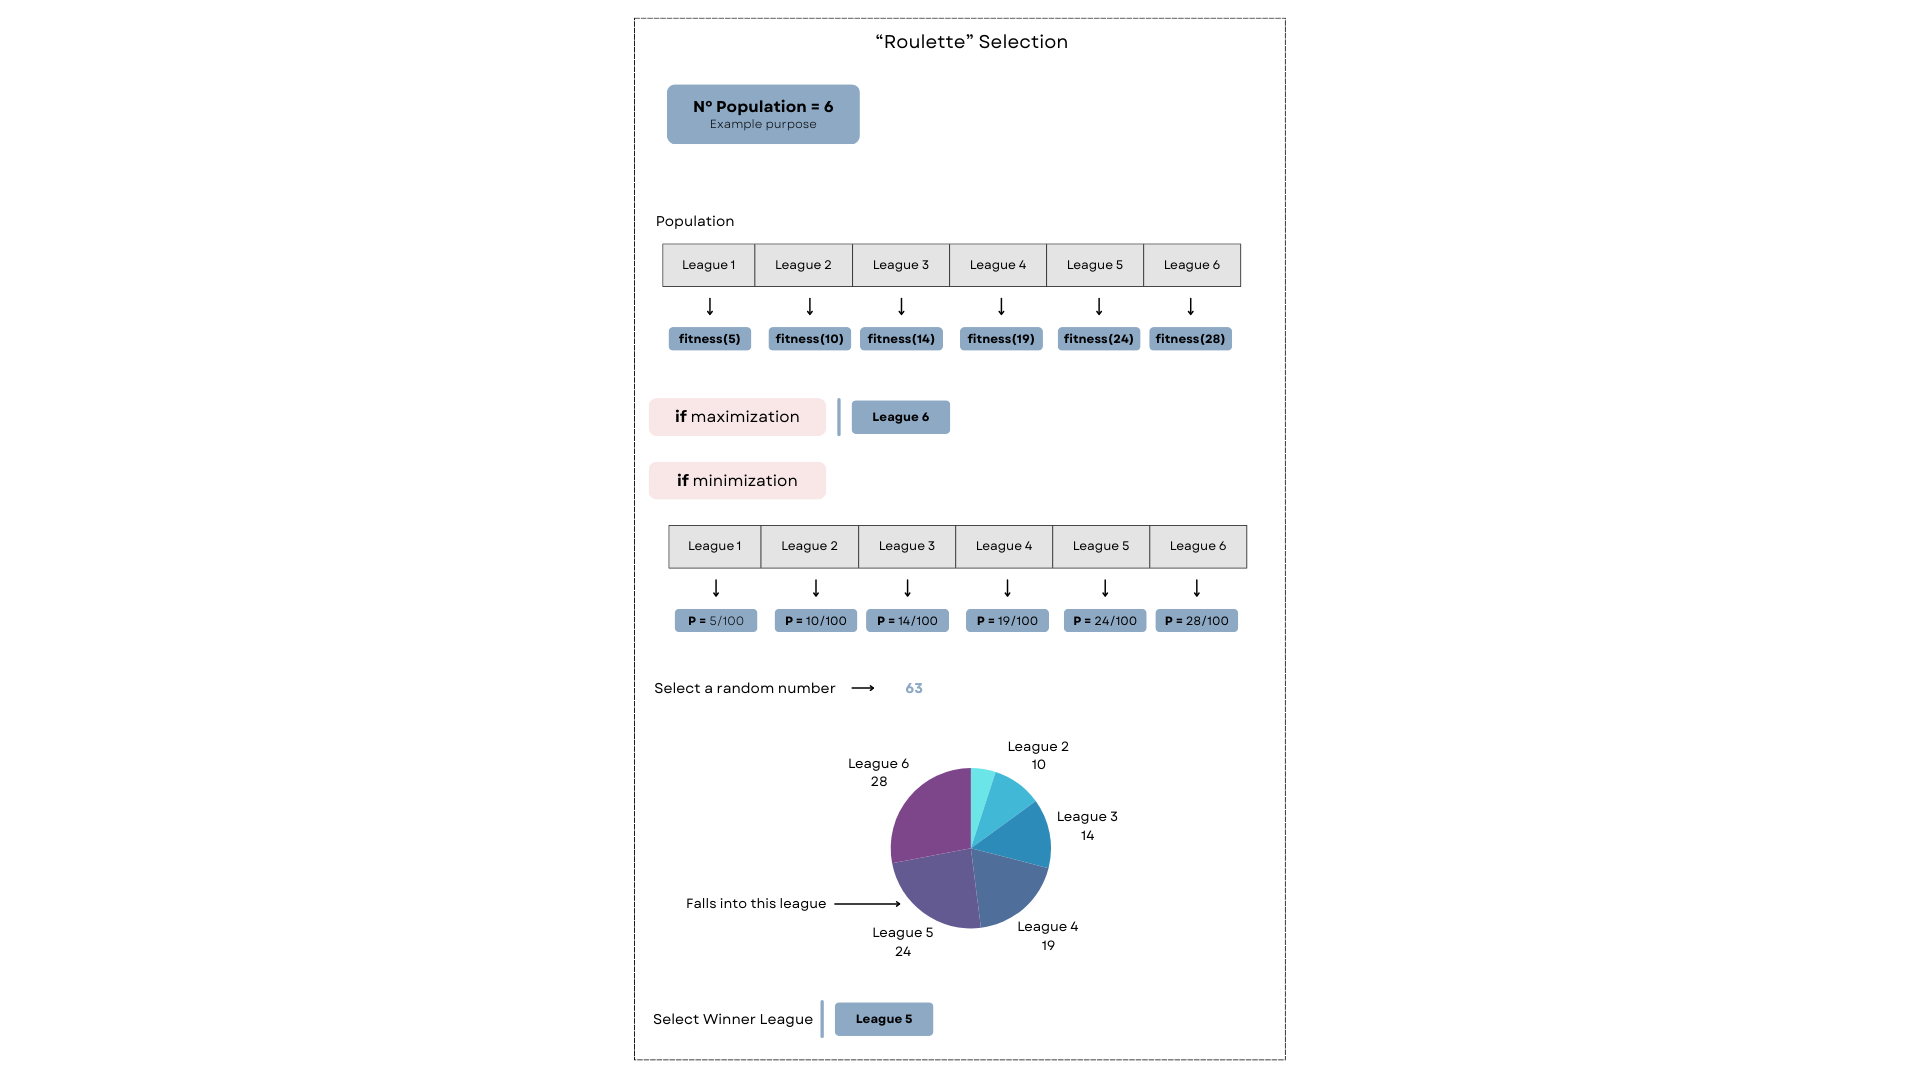

</div>

<h2 id="chapter6" style="color:#8DA9C4;">6. Genetic Algorithm</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>This section implements a customizable genetic algorithm that evolves a population of solutions over multiple generations. Key components include:</p>

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<ul>
  <li><strong style="color:#8DA9C4;">Selection:</strong> Configurable via external strategies such as tournament or fitness-proportionate selection.</li>
  <li><strong style="color:#8DA9C4;">Crossover:</strong> Applied with a probability (<code>xo_prob</code>) to generate new individuals by recombining parents.</li>
  <li><strong style="color:#8DA9C4;">Mutation:</strong> Introduces variation in offspring based on a defined mutation rate (<code>mut_prob</code>).</li>
  <li><strong style="color:#8DA9C4;">Elitism (optional):</strong> When enabled, the best individual of each generation is preserved to ensure solution quality is not lost.</li>
  <li><strong style="color:#8DA9C4;">Maximization/Minimization:</strong> Controlled via the <code>maximization</code> flag to adapt to different objective types.</li>
</ul>

<p>The algorithm records the best fitness of each generation, allowing for performance tracking over time.</p>


</div>


In [12]:
def get_best_ind(population: list[League], maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]

In [15]:
def genetic_algorithm(
    initial_population: list[League],   # MUDAR ISTO PARA LISTA DE SOLUTION
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
    ):

    population = initial_population
    fitness_list = []

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f"------------ Generation {gen} ------------")

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            first_ind = selection_algorithm(population=population, maximization=maximization)

            second_ind = selection_algorithm(population=population, maximization=maximization)

            if verbose:
                print(f"Selected Individuals: \n{first_ind}\n{second_ind}")

            if random.random() < xo_prob:
                offspring1, offspring2 = first_ind.crossover(second_ind)
                if verbose:
                    print("Applied Crossover")
            else:
                offspring1, offspring2 = deepcopy(first_ind), deepcopy(second_ind)
                if verbose:
                    print("Not Applied Replication")

            if verbose:
                print(f"Offspring 1: {offspring1}\n{offspring2}")

            first_new_ind = offspring1.mutation(mut_prob)
            new_population.append(first_new_ind)

            if verbose:
                print(f"First mutated individual: {first_new_ind}")

            if len(new_population) < len(population):
                second_new_ind = offspring2.mutation(mut_prob)
                new_population.append(second_new_ind)
                if verbose:
                    print(f"Second mutated individual: {second_new_ind}")

        population = new_population
        fitness_list.append(get_best_ind(population, maximization).fitness())

        if verbose:
            print(f"Final Best Individual in Generation: {get_best_ind(population, maximization)}")

    return get_best_ind(population, maximization), fitness_list


<h2 id="chapter7" style="color:#8DA9C4;">7. Grid Search</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p></p>



In [16]:
# SEED = 40
# random.seed(SEED)
# np.random.seed(SEED)

# POP_SIZE = 10
# GENERATIONS = 20

# grid_params = {
#     "crossover": [
#         {
#             "function": cycle_crossover,
#             "xo_prob": 0.9
#         },
#         {
#             "function": swap_crossover,
#             "xo_prob": 0.9
#         }
#     ],
#     "mutation": [
#         {
#             "function": shift_mutation,
#             "mut_prob": 0.1
#         },
#         {
#             "function": invertion_mutation,
#             "mut_prob": 0.1
#         },
#         {
#             "function": swap_mutation,
#             "mut_prob": 0.1
#         }
#     ],
#     "selection": [
#         {
#             "function": fitness_proportionate_selection,
#             "maximization": False
#         },
#         {
#             "function": tournament_selection,
#             "tournament_size": 4,
#             "maximization": False
#         }
#     ]
#     #"elitism": [True, False]                       # ELETISM CONFIGS
# }

# fitness_dfs = {}

# #grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"], grid_params["elitism"]))
# grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"]))                     # ELETISM CONFIGS

# print(f"Number of configs: {len(grid)}")


# #for crossover_cfg, mutation_cfg, selection_cfg, elitism in tqdm(grid):
# for crossover_cfg, mutation_cfg, selection_cfg in grid:             # UNCOMMENT FOR ELETISM CONFIGS

#     # Create empty dataframe for each configuration
#     # Columns have the fitness in each generation, rows will have results for each run
#     df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 200

#     # Get crossover and mutation functions and probabilities from the grid
#     crossover_function = crossover_cfg["function"]
#     xo_prob = crossover_cfg["xo_prob"]
#     mutation_function = mutation_cfg["function"]
#     mut_prob = mutation_cfg["mut_prob"]
#     selection_function = selection_cfg["function"]
#     if selection_function == tournament_selection:
#         tournament_size = selection_cfg["tournament_size"]
#     maximization = selection_cfg["maximization"]

#     config_results = []

#     for run_nr in tqdm(range(30)):



#         initial_population = []

#         for _ in range(POP_SIZE):
#             players = [Player(row) for _, row in players_df.iterrows()]
#             league = League(swap_crossover, swap_mutation)
#             league.draft_players(players)
#             initial_population.append(league)

#         _, fitness_over_gens = genetic_algorithm(
#             initial_population=initial_population,
#             max_gen=GENERATIONS,
#             selection_algorithm=fitness_proportionate_selection,
#             maximization=False,
#             mut_prob=0.1,
#             verbose=False
#         )
#         config_results.append(fitness_over_gens)
#         df.loc[run_nr] = fitness_over_gens

#         selection_name = selection_function.__name__
#         if selection_function == tournament_selection:
#             selection_name += f"(k={selection_cfg['tournament_size']})"

#         config_label = (
#           f"{crossover_function.__name__}{xo_prob}_"
#           f"{mutation_function.__name__}{mut_prob}_"
#           f"{selection_name}"
#           #f"_elitism={elitism}"      # UNCOMMENT FOR ELETISM CONFIGS
#         )

#     df.to_csv(f"results/fitness_{config_label}.csv", index=False)

#     fitness_dfs[config_label] = df

<h2 id="chapter8" style="color:#8DA9C4;">8. Visualization</h2>

<p><a href="#toc" style="color:#8DA9C4;">⬅ Back to Table of Contents</a></p>

<p>In this section, we visualize the outcomes and behavior of the genetic algorithm across generations. These plots help interpret the model's convergence and provide insights into the effectiveness of the evolutionary process.</p>

<div style="border-left: 6px solid #8DA9C4; padding: 10px; border-radius: 8px;">

<p>Common visualizations include:</p>

<ul>
  <li><strong style="color:#8DA9C4;">Fitness Evolution:</strong> A line plot showing how the best, worst, or average fitness scores change across generations. This indicates whether the population is improving over time.</li>
  
  <li><strong style="color:#8DA9C4;">Team Composition:</strong> Bar charts or tables to display the final configuration of players per team, helping to assess balance, diversity, and budget use.</li>
  
  <li><strong style="color:#8DA9C4;">Selection Distribution:</strong> (Optional) Histogram or pie chart to show which individuals were selected more often, indicating selection pressure or bias.</li>
</ul>

<p>These graphical summaries support both debugging and result interpretation, making the optimization process more transparent and easier to evaluate.</p>

</div>


## TEM QUE SE MUDAR

Best solution: (<__main__.League object at 0x00000183A66FA840>, [0.35571141708538767, 0.35571141708538767, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.119522860

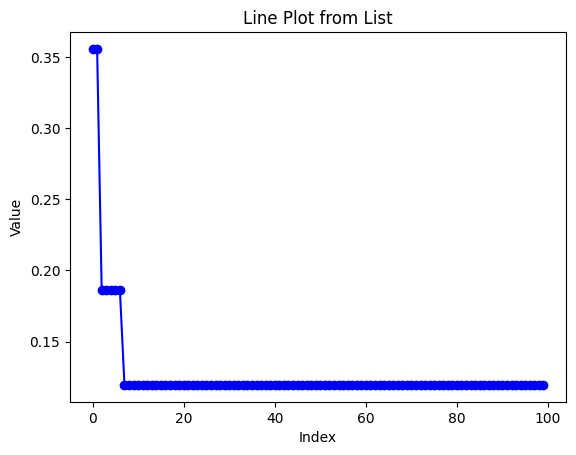

In [17]:
SEED = 40
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
initial_population = []


for _ in range(POP_SIZE):
    players = [Player(row) for _, row in players_df.iterrows()]
    league = League(cycle_crossover, swap_mutation)
    league.draft_players(players)
    initial_population.append(league)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=100,
    selection_algorithm=fitness_proportionate_selection,
    maximization=False,
    mut_prob=0.1,
    verbose=False
)

print("Best solution:", best_solution)
print("Fitness:", best_solution[0].fitness())
print("Fitness List:", best_solution[1])


# Create a line plot
plt.plot(best_solution[1], marker='o', linestyle='-', color='b')

# Optional: Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot from List')

# Show the plot
plt.show()

In [18]:
best_solution[0].show_teams()


Team 1
──────────────
Blake Henderson - GK
Lucas Bennett - DEF
Logan Brooks - DEF
Spencer Ward - MID
Austin Torres - MID
Chase Murphy - FWD
Sebastian Perry - FWD

Team 2
──────────────
Ryan Mitchell - GK
Daniel Foster - DEF
Owen Parker - DEF
Ashton Phillips - MID
Dominic Bell - MID
Landon Powell - FWD
Tyler Jenkins - FWD

Team 3
──────────────
Chris Thompson - GK
Ethan Howard - DEF
Brayden Hughes - DEF
Connor Hayes - MID
Dylan Morgan - MID
Colton Gray - FWD
Zachary Nelson - FWD

Team 4
──────────────
Jordan Smith - GK
Caleb Fisher - DEF
Jaxon Griffin - DEF
Bentley Rivera - MID
Hunter Cooper - MID
Elijah Sanders - FWD
Xavier Bryant - FWD

Team 5
──────────────
Alex Carter - GK
Maxwell Flores - DEF
Mason Reed - DEF
Nathan Wright - MID
Gavin Richardson - MID
Adrian Collins - FWD
Julian Scott - FWD
──────────────


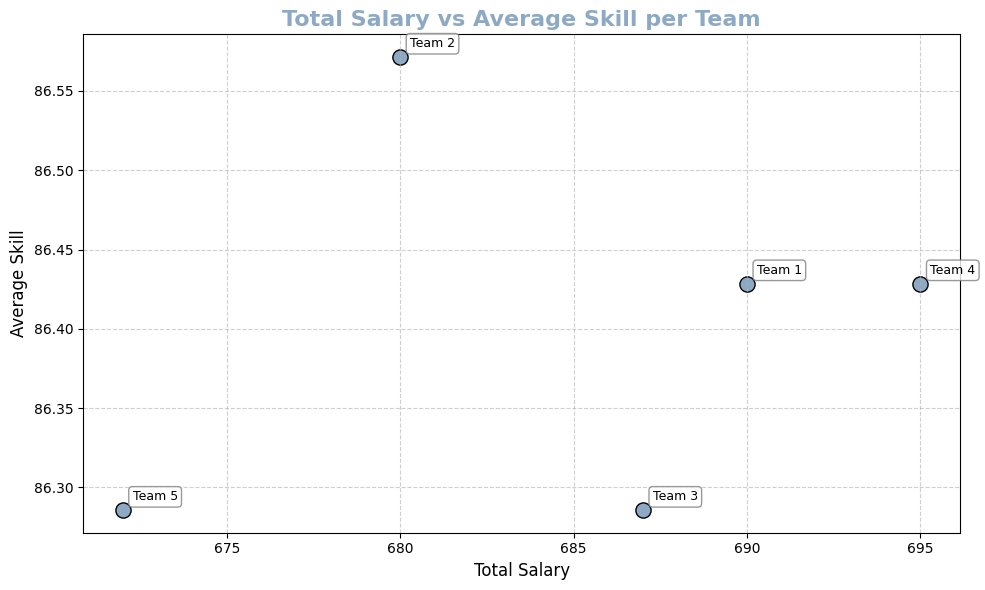

In [24]:
import matplotlib.pyplot as plt

# Extract necessary data from the best solution's teams
total_salaries = [team.total_salary() for team in best_solution[0].teams]
average_skills = [team.average_skill() for team in best_solution[0].teams]
team_labels = [f"Team {i+1}" for i in range(len(best_solution[0].teams))]

# Define your custom color
custom_color = '#8DA9C4'

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot with styled points
plt.scatter(
    total_salaries,
    average_skills,
    color=custom_color,         # Custom color for your brand
    s=120,                      # Larger point size
    edgecolor='black',         # Black edge for better contrast
    linewidth=1
)

# Annotate each point with its team label
for i, label in enumerate(team_labels):
    plt.annotate(
        label,
        (total_salaries[i], average_skills[i]),
        textcoords="offset points",
        xytext=(7, 7),           # Text offset
        ha='left',
        fontsize=9,
        bbox=dict(
            boxstyle="round,pad=0.3",
            edgecolor="gray",
            facecolor="white",
            alpha=0.8            # Slight transparency for a modern look
        )
    )

# Set titles and labels with enhanced formatting
plt.title('Total Salary vs Average Skill per Team', fontsize=16, fontweight='bold', color=custom_color)
plt.xlabel('Total Salary', fontsize=12)
plt.ylabel('Average Skill', fontsize=12)

# Add a clean grid
plt.grid(True, linestyle='--', alpha=0.6)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()
